In [1]:
import csv
import pandas as pd
import numpy as np
import os
from binance.client import Client
import time
import re
import requests
import gdax
from datetime import datetime
import string
import random
import coinbase
from coinbase.wallet.client import OAuthClient, Client
import matplotlib.pyplot as plt

In [36]:
api_input = open("APIKeyBin.txt", "r")
codes = api_input.readlines()
codes = [code.rstrip('\n') for code in codes]
api_key = codes[0]
api_secret = codes[1]

FileNotFoundError: [Errno 2] No such file or directory: 'APIKeyBin.txt'

In [251]:
# Gather data, rename files as necessary
btc = pd.read_csv("BTCfills(12_21_17).csv")
eth = pd.read_csv("ETHfills(12_22_17).csv")
ltc = pd.read_csv("LTCfills(12_21_17).csv")
alts = pd.read_csv("OrderHistory.csv")

In [252]:
btc

,trade id,product,side,created at,size,size unit,price,fee,total,price/fee/total unit
0,23419416,BTC-USD,SELL,2017-11-08T17:28:41.965Z,0.059822,BTC,7800.00,0.000000,466.609260,USD
1,23500329,BTC-USD,BUY,2017-11-09T07:48:16.687Z,0.067610,BTC,7376.95,1.246883,-499.999964,USD
2,24375436,BTC-USD,SELL,2017-11-17T00:25:38.578Z,0.017521,BTC,7934.98,0.347578,138.683429,USD
3,25471432,BTC-USD,SELL,2017-11-30T01:54:35.492Z,0.033985,BTC,10484.00,0.000000,356.295071,USD
4,25852043,BTC-USD,BUY,2017-12-02T23:16:27.125Z,0.010000,BTC,11006.93,0.000000,-110.069300,USD
5,25852067,BTC-USD,SELL,2017-12-02T23:16:57.654Z,0.018604,BTC,11006.94,0.000000,204.778285,USD


In [253]:
btc_earnings = btc['total'].sum()

In [254]:
eth_earnings = eth['total'].sum()

In [255]:
ltc_earnings = ltc['total'].sum()

In [256]:
alts.head()

,Date,Pair,Type,Order Price,Order Amount,Avg Trading Price,Filled,Total,status
0,2017-12-21 05:55:06,MODBTC,SELL,0.0001562,102.21,0.0001563,102.210,0.015976,Filled
1,NaN,Date,Trading Price,Filled,Total,Fee,NaN,NaN,NaN
2,NaN,2017-12-21 05:55:06,0.0001563,102.21,0.01597542,0.00001598BTC,NaN,NaN,NaN
3,2017-12-20 08:56:43,XMRBTC,BUY,0.023801,0.692,0.023801,0.692,0.016471,Filled
4,NaN,Date,Trading Price,Filled,Total,Fee,NaN,NaN,NaN


In [257]:
alts_trans = alts.dropna(subset=['Date'])
alts_filled = alts_trans[alts_trans['status'] == 'Filled']
negated_sells = alts_filled.apply(lambda x: x.loc['Total'] if x.loc['Type'] == 'SELL' else -x.loc['Total'], axis=1).astype('float')
negated_coins = alts_filled.apply(lambda x: x.loc['Order Amount'] if x.loc['Type'] == 'SELL' else -float(x.loc['Order Amount']), axis=1).astype('float')
alts_filled.loc[:, 'Total'] = negated_sells
alts_filled.loc[:, 'Order Amount'] = negated_coins
buy_sell_amts = alts_filled.groupby(['Pair', 'Type'])[['Order Amount', 'Total']].sum()
buy_sell_amts

/Users/jacky/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Order Amount        Total
Pair    Type                           
ARKBTC  BUY     -35.000000    -0.015558
        SELL     34.960000     0.012928
BTCUSDT BUY      -0.124588 -1841.370000
        SELL      0.131097  1843.210000
ETHBTC  BUY      -0.945000    -0.032604
IOTABTC BUY    -300.000000    -0.050137
        SELL    299.000000     0.050318
LTCBTC  BUY      -4.690000    -0.072435
        SELL     10.070000     0.165576
MODBTC  BUY    -152.320000    -0.027642
        SELL    152.160000     0.028004
QTUMBTC BUY      -7.000000    -0.011697
        SELL      6.990000     0.012589
TRXBTC  SELL    500.000000     0.000130
WTCBTC  BUY     -15.000000    -0.012646
        SELL     14.000000     0.009114
XMRBTC  BUY      -2.182000    -0.046423
        SELL      0.544000     0.013056

In [258]:
profits = buy_sell_amts.groupby('Pair').sum()
profits = profits.filter(regex='BTC$', axis = 0)
curr_btc_price = float(input("Current BTC price in USD: ").replace(',', ''))
profits_in_usd = pd.DataFrame()
profits_in_usd['Amount of Coin in Binance'] = profits['Order Amount']
profits_in_usd['Total'] = profits['Total'].apply(lambda x: x * curr_btc_price)

Current BTC price in USD: 13000


In [259]:
profits_in_usd

,Amount of Coin in Binance,Total
Pair,,
ARKBTC,-0.040,-34.18090
ETHBTC,-0.945,-423.85200
IOTABTC,-1.000,2.35521
LTCBTC,5.380,1210.83300
MODBTC,-0.160,4.70470
QTUMBTC,-0.010,11.59600
TRXBTC,500.000,1.69000
WTCBTC,-1.000,-45.92159
XMRBTC,-1.638,-433.77100


In [260]:
alts_earnings = profits_in_usd.sum()

In [261]:
alts_earnings + btc_earnings + eth_earnings + ltc_earnings

Amount of Coin in Binance    874.466211
Total                        667.332631
dtype: float64

In [262]:
btc_earnings

556.2967804399215

In [263]:
eth_earnings

-314.509168702054

In [264]:
ltc_earnings

132.09159926903092

In [33]:
client = Client(api_key, api_secret)

NameError: name 'api_key' is not defined

In [32]:
client.get_deposit_history()

NameError: name 'client' is not defined

In [190]:
# get all trades from all symbols

all_symbols = client.get_all_tickers()
all_symbols = [coin['symbol'] for coin in all_symbols]

trades = []
for symbol in all_symbols:
    this_coins_trade = client.get_my_trades(symbol = symbol)
    for trade in this_coins_trade:
        trade['symbol'] = symbol
    trades.extend(this_coins_trade)
    time.sleep(0.1)


In [223]:
trades_df = pd.DataFrame(trades)
trades_df['coinOfInterest'] = trades_df['symbol'].apply(lambda x: re.sub(r'BTC$|USDT$', '', x))
coin_of_basis = trades_df.apply(lambda x: x['symbol'].replace(x['coinOfInterest'], ''), axis=1)
trades_df['coinOfBasis'] = coin_of_basis
trades_df

,commission,commissionAsset,id,isBestMatch,isBuyer,isMaker,orderId,price,qty,symbol,time,coinOfInterest,coinOfBasis
0,0.00046700,ETH,6158916,True,True,True,26691743,0.03450100,0.46700000,ETHBTC,1513088433121,ETH,BTC
1,0.00008000,ETH,6158917,True,True,True,26691743,0.03450100,0.08000000,ETHBTC,1513088433234,ETH,BTC
2,0.00008000,ETH,6158918,True,True,True,26691743,0.03450100,0.08000000,ETHBTC,1513088433333,ETH,BTC
3,0.00004100,ETH,6158919,True,True,True,26691743,0.03450100,0.04100000,ETHBTC,1513088433661,ETH,BTC
4,0.00015000,ETH,6158920,True,True,True,26691743,0.03450100,0.15000000,ETHBTC,1513088433721,ETH,BTC
5,0.00012700,ETH,6158921,True,True,True,26691743,0.03450100,0.12700000,ETHBTC,1513088434079,ETH,BTC
6,0.00001601,BTC,1815340,True,False,False,11156093,0.01469000,1.09000000,LTCBTC,1513076134922,LTC,BTC
7,0.00005450,BTC,1815344,True,False,True,11156093,0.01469000,3.71000000,LTCBTC,1513076135898,LTC,BTC
8,0.00228000,LTC,1815665,True,True,True,11156932,0.01459200,2.28000000,LTCBTC,1513076332906,LTC,BTC
9,0.00002449,BTC,1830042,True,False,True,11186707,0.01749500,1.40000000,LTCBTC,1513081852082,LTC,BTC


In [2]:
# TODO: automate keys creation (pull from product ticker or something)
tables = {'BTC': None, 'ETH': None, 'LTC': None}

In [26]:
api_input = open("APIKeyGDAX.txt", "r")
codes = api_input.readlines()
codes = [code.rstrip('\n') for code in codes]
GDAXapi_key = codes[0]
GDAXapi_secret = codes[1]
GDAXpass = codes[2]

In [27]:
auth_client = gdax.AuthenticatedClient(GDAXapi_key, GDAXapi_secret, GDAXpass)

In [28]:
request = auth_client.get_accounts()

In [29]:
holdings = pd.DataFrame(request)
holdings

,available,balance,currency,hold,id,profile_id
0,526.51,917.7100000000000000,USD,391.2000000000000000,bcbdb4d6-af62-411a-89aa-4f9d371fe76c,10958c4a-acd1-485a-8cbc-8de40a185c1e
1,0,1.0000000000000000,LTC,1.0000000000000000,08caade3-0eb1-4710-bee3-e7891c2eda44,10958c4a-acd1-485a-8cbc-8de40a185c1e
2,0,0.0000000000000000,ETH,0.0000000000000000,7ce1227d-d07c-431c-bcb7-fd2b50f8ff48,10958c4a-acd1-485a-8cbc-8de40a185c1e
3,0.01,0.0100000000000000,BTC,0.0000000000000000,b51c06c2-1d01-4663-a3cd-277e04fd0f9c,10958c4a-acd1-485a-8cbc-8de40a185c1e
4,0,0.0000000000000000,BCH,0.0000000000000000,47bb32d3-7db3-45ab-a1a2-62ad45f25b0e,10958c4a-acd1-485a-8cbc-8de40a185c1e


In [30]:
profile_ids = {account['currency']: account['id'] for account in request}

In [31]:
# fix this, doesn't make sense for files to start out empty
files = {}

In [32]:
profile_ids

{'BCH': '47bb32d3-7db3-45ab-a1a2-62ad45f25b0e',
 'BTC': 'b51c06c2-1d01-4663-a3cd-277e04fd0f9c',
 'ETH': '7ce1227d-d07c-431c-bcb7-fd2b50f8ff48',
 'LTC': '08caade3-0eb1-4710-bee3-e7891c2eda44',
 'USD': 'bcbdb4d6-af62-411a-89aa-4f9d371fe76c'}

In [25]:
auth_client.get_account_history(profile_ids['LTC'])

[[{'amount': '1.0000000000000000',
   'balance': '1.5000000000000000',
   'created_at': '2017-12-26T05:24:38.268715Z',
   'details': {'order_id': '90fdfa1c-f7a9-4733-9677-a591d7579c71',
    'product_id': 'LTC-USD',
    'trade_id': '20902470'},
   'id': 580750792,
   'type': 'match'},
  {'amount': '0.5000000000000000',
   'balance': '0.5000000000000000',
   'created_at': '2017-12-21T05:21:57.836593Z',
   'details': {'order_id': 'c026765a-4da1-4c2c-b9ea-a95e4ca2a16c',
    'product_id': 'LTC-USD',
    'trade_id': '19919431'},
   'id': 551486901,
   'type': 'match'},
  {'amount': '-0.9183654900000000',
   'balance': '0.0000000000000000',
   'created_at': '2017-12-21T04:39:03.360988Z',
   'details': {'order_id': 'ef61ac38-cea6-4328-9da7-3dfd72124abe',
    'product_id': 'LTC-USD',
    'trade_id': '19906618'},
   'id': 551259960,
   'type': 'match'},
  {'amount': '-2.3000000000000000',
   'balance': '0.9183654900000000',
   'created_at': '2017-12-15T15:25:48.359079Z',
   'details': {'order_id

In [34]:
fills = auth_client.get_fills()

In [35]:
fills

[[{'created_at': '2018-01-05T22:41:22.899Z',
   'fee': '0.0000000000000000',
   'liquidity': 'M',
   'order_id': 'f0dc4e6c-f134-495a-a6d4-f4afe86cfc3e',
   'price': '16950.00000000',
   'product_id': 'BTC-USD',
   'profile_id': '10958c4a-acd1-485a-8cbc-8de40a185c1e',
   'settled': True,
   'side': 'sell',
   'size': '0.01500000',
   'trade_id': 32217913,
   'usd_volume': '254.2500000000000000',
   'user_id': '5a2f4217546c0c013c69c628'},
  {'created_at': '2017-12-21T19:07:11.442Z',
   'fee': '0.0000000000000000',
   'liquidity': 'M',
   'order_id': 'c9558097-039e-4416-b23f-9ead4e52994f',
   'price': '15428.00000000',
   'product_id': 'BTC-USD',
   'profile_id': '10958c4a-acd1-485a-8cbc-8de40a185c1e',
   'settled': True,
   'side': 'buy',
   'size': '0.02500000',
   'trade_id': 29476566,
   'usd_volume': '385.7000000000000000',
   'user_id': '5a2f4217546c0c013c69c628'},
  {'created_at': '2018-01-02T01:57:00.021Z',
   'fee': '0.0000000000000000',
   'liquidity': 'M',
   'order_id': '03bdb

In [27]:
fills_df = pd.DataFrame(fills[0])
fills_df['created_at'] = fills_df['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
fills_df = fills_df.sort_values(by='created_at').reset_index(drop=True)

In [ ]:
fills_df

In [36]:
def get_average_price(coin, table):
    #checks
    table = table.sort_values(by='created_at').reset_index(drop=True)
    unique_coins = table['product_id'].unique()
    unique_coins = [str(coin_ex) for coin_ex in unique_coins]
    if 'nan' in unique_coins and len(unique_coins) != 2:
        print("More than one currency in average price check")
        return
    elif 'nan' not in unique_coins and len(unique_coins) != 1:
        print("More than one currency in average price check")
        return
    start_index = 0
    table['price'] = table['price'].astype(float)
    table['size'] = table['size'].astype(float)
    if 'rolling_average' in table.columns:
        index = table['rolling_average'].index[table['rolling_average'].apply(np.isnan)]
        table_index = table.index.values.tolist()
        if len(index) != 0:
            start_index = table_index.index(index[0])
        else:
            start_index = len(table)
    if start_index == 0:
        table['rolling_average'] = pd.Series(table.loc[0, 'price'])
        table['rolling_stash'] = pd.Series(table.loc[0, 'size'])
        start_index += 1
    curr_price_index = start_index
    while curr_price_index < len(table):
        if table['type'][curr_price_index] == 'buy' or table['type'][curr_price_index] == 'deposit':
            prev_price = table['rolling_average'][curr_price_index-1]
            prev_stash = table['rolling_stash'][curr_price_index-1]
            this_price = table['price'][curr_price_index]
            this_stash = table['size'][curr_price_index]
            total_stash = prev_stash + this_stash
            table.loc[curr_price_index, 'rolling_average'] = (prev_price*(prev_stash/total_stash)) + (this_price*(this_stash/total_stash))
            table.loc[curr_price_index, 'rolling_stash'] = total_stash
        else:
            remove_stash = table['size'][curr_price_index]
            table.loc[curr_price_index, 'rolling_average'] = table['rolling_average'][curr_price_index-1]
            table.loc[curr_price_index, 'rolling_stash'] = table['rolling_stash'][curr_price_index-1] + remove_stash
        curr_price_index += 1
    tables[coin] = table
    return table

In [37]:
# pass in fills of one type of coin
# coin here is coin
def update_fills_table(coin):
    fills = auth_client.get_fills(product_id=coin + '-USD')
    old_table = None
    fills_list = []
    for fill_page in fills:
        fills_list.extend(fill_page)
    fills_df = pd.DataFrame(fills_list)
    fills_df.loc[:, 'created_at'] = fills_df['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
    if tables[coin] is not None:
        old_table = tables[coin]
        latest_date = get_latest_date(old_table)
        fills_df = fills_df[fills_df['created_at'] > latest_date]
    fills_df = fills_df.sort_values(by='created_at').reset_index(drop=True)
#     product_id = coin + '-USD'
#     coin_chart = fills_df[fills_df['product_id'] == product_id].reset_index(drop=True)
    fills_df.rename(columns = {'side':'type'}, inplace = True)
    fills_df['size'] = fills_df['size'].astype(float)
    fills_df['fee'] = fills_df['fee'].astype(float)
    fills_df['price'] = fills_df['price'].astype(float)
    fills_df['usd_volume'] = fills_df['usd_volume'].astype(float)
    fills_df['trade_id'] = fills_df['trade_id'].astype(str)
    if len(fills_df) != 0:
        negated_sells = fills_df.apply(lambda x: -x.loc['size'] if x.loc['type'] == 'sell' else x.loc['size'], axis=1)
        negated_sells = negated_sells.astype(float)
        fills_df['size'] = negated_sells
    return fills_df

In [51]:
# pass in transfers of one type of coin
# coin here is just the coin (e.g. 'ETH')
def update_transfers_table(coin):
    account_history = auth_client.get_account_history(profile_ids[coin])
    combined_list = []
    for account_page in account_history:
        combined_list.extend(account_page)
    coin_hist = pd.DataFrame(combined_list)
    coin_transfers = coin_hist[coin_hist['type'] == 'transfer']
    coin_transfers.loc[:, 'created_at'] = coin_transfers['created_at'].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

    if tables[coin] is not None:
        old_table = tables[coin]
        latest_date = get_latest_date(old_table)
        coin_transfers = coin_transfers[coin_transfers['created_at'] > latest_date]
    coin_transfers.loc[:, 'transfer_id'] = coin_transfers['details'].apply(lambda x: x.get('transfer_id'))
    coin_transfers.rename(columns={'amount': 'size'}, inplace=True)
    coin_transfers.loc[:, 'id'] = coin_transfers['id'].astype(str)
    coin_transfers.loc[:, 'size'] = coin_transfers['size'].astype(float)
    coin_transfers = coin_transfers.reset_index(drop=True)
    prices = []
    types = []
    for index, row in coin_transfers.iterrows():
        if row['size'] < 0:
            cost = float(input(
                "What is the price (in USD) of the {0} {1} for the withdrawal at {2}".format(-row['size'], coin,
                                                                                            row['created_at'])))
            price = cost / (-row['size'])
            prices.append(price)
            types.append('withdrawal')
        else:
            cost = float(input(
                "What is the price (in USD) of the {0} {1} for the deposit at {2}".format(row['size'], coin,
                                                                                         row['created_at'])))
            price = cost / row['size']
            prices.append(price)
            types.append('deposit')
    prices_series = pd.Series(prices)
    types_series = pd.Series(types)
    coin_transfers.loc[:, 'price'] = prices_series
    coin_transfers.loc[:, 'type'] = types_series
    return coin_transfers

In [39]:
def get_latest_date(table):
    sorted_table = table.sort_values(by='created_at')
    return sorted_table.tail(1)['created_at'].values[0]

In [40]:
def append_transfers(transfers, main_table):
    transfers = transfers.loc[:, ['size', 'created_at', 'id', 'type', 'transfer_id', 'price']]
    main = pd.concat([main_table, transfers], ignore_index=True)
    main = main.sort_values(by='created_at').reset_index(drop=True)
    return main

In [41]:
def drop_nonessential(table):
    columns_to_drop = set(['order_id', 'id', 'trade_id', 'user_id', 'liquidity', 'profile_id', 'transfer_id'])
    columns_exist = columns_to_drop.intersection(table.columns)
    if list(columns_exist) != []:
        dropped_table = table.drop(list(columns_exist), axis=1)
    return dropped_table

In [42]:
def create_csv(table):
    coin = get_product_id(table)
    name = coin+'_summary.csv'
    table.to_csv(name, index=False)
    files[coin] = name
    

In [43]:
def get_product_id(table):
    coins = table['product_id'].unique()
    clean_coins = [x for x in coins if str(x) != 'nan']
    if len(clean_coins) > 1:
        print("More than one coin in table being saved.")
    if len(clean_coins) == 0:
        print("No coins in table")
    coin = clean_coins[0]
    return coin

In [44]:
def get_gains(table):
    sells_withdraws = table[(table['type'] == 'sell') | (table['type'] == 'withdraw')]
    price_diff = (sells_withdraws['price'] - sells_withdraws['rolling_average'])*np.negative(sells_withdraws['size'])
    return price_diff.sum()

In [45]:
def gains_if_sell_now(table):
    product_id = get_product_id(table)
    price = float(auth_client.get_product_ticker(product_id)['price'])
    gains = get_gains(table)
    flush_out = (price - table.tail(1)['rolling_average'].values[0]) * (table.tail(1)['rolling_stash'].values[0])
    current_gains = gains + flush_out
    return current_gains

In [46]:
def set_types(table):
    table['created_at'] = pd.to_datetime(table['created_at'])
    table['trade_id'] = table['trade_id'].astype(str)
    table['id'] = table['id'].astype(str)

    return table

In [47]:
price_overnight = []

In [48]:
coins = ['BTC', 'ETH', 'LTC']

In [56]:

for coin in coins:
    file_path = coin+'-USD_summary.csv'
    if os.path.isfile(file_path):
        tables[coin] = set_types(pd.read_csv(file_path))
    else:
        tables[coin] = None

for coin in coins:
    update_fills = update_fills_table(coin)
    update_transfers = update_transfers_table(coin)
    update_table = append_transfers(update_transfers, update_fills)
    new_table = pd.concat([tables[coin], update_table])
    new_table = new_table.sort_values(by='created_at').reset_index(drop=True)
    tables[coin] = get_average_price(coin, new_table)


for table in tables.values():
    create_csv(table)


profits = 0
for coin in coins:
    profits += gains_if_sell_now(tables[coin])
price_overnight.append(profits)
print(profits)

/Users/jacky/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/jacky/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jacky/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

What is the price (in USD) of the 2.0 LTC for the deposit at 2017-12-12 10:03:45.666502485.20
332.1601


In [55]:
drop_nonessential(tables['ETH'])

,created_at,fee,price,product_id,rolling_average,rolling_stash,settled,size,type,usd_volume
0,2017-12-13 18:20:44.835,0.0,677.0,ETH-USD,677.0,0.3,True,0.3,buy,203.1
1,2017-12-15 02:20:51.331,0.0,661.0,ETH-USD,670.6,0.5,True,0.2,buy,132.2
2,2017-12-18 19:11:48.417,0.0,774.0,ETH-USD,670.6,0.0,True,-0.5,sell,387.0
3,2017-12-22 03:08:46.819,0.0,705.0,ETH-USD,705.0,0.6,True,0.6,buy,423.0
4,2018-01-02 01:57:00.021,0.0,845.0,ETH-USD,705.0,0.0,True,-0.6,sell,507.0


In [57]:
price_overnight

[1588.3778759786983,
 1589.3473337768983,
 1588.2046459218982,
 1590.445021631898,
 1590.624905445798,
 1590.7216753889979,
 1591.0966753889979,
 1590.6615592028982,
 1592.8337048560982,
 1593.4120510989983,
 1593.5620510989982,
 1593.585397341898,
 1593.6520510989981,
 1594.4886661273981,
 1597.6798822917983,
 1597.478228534698,
 1597.4932285346981,
 1597.4715747775981,
 1597.4932285346981,
 1596.863228534698,
 1597.489843563098,
 1600.2449481721978,
 1601.0916019292981,
 1601.3515632005983,
 1602.5145608851981,
 1611.5008700816982,
 1614.3067492647983,
 1614.3284030218983,
 1614.3284030218983,
 1614.523403021898,
 1614.7184030218982,
 1613.0767492647981,
 1612.311102453898,
 1612.4246810689981,
 1609.7680388888982,
 1611.3106492864981,
 1613.888027311898,
 1610.083038888898,
 1608.711617503998,
 1608.6966175039979,
 1609.1080388888981,
 1613.6722527378981,
 1611.8797197976983,
 1611.0697197976981,
 1611.1730273118983,
 1613.6207151668982,
 1615.6334030218982,
 1615.626749264798,
 161

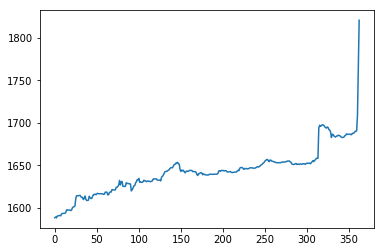

In [58]:
plt.plot(price_overnight)
plt.show()

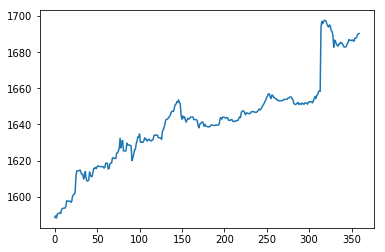

In [53]:
plt.plot(price_overnight)
plt.show()

In [64]:
coinbase_input = open("APIKeyCoinbase.txt", "r")
codes = coinbase_input.readlines()
codes = [code.rstrip('\n') for code in codes]
coinbase_api_key = codes[0]
coinbase_api_secret = codes[1]
# client_id = codes[1]
# client_secret = codes[2]

In [65]:
client = Client(coinbase_api_key, coinbase_api_secret)


In [ ]:
access_token = input("Access token: ")
# refresh_token = input("Refresh token: ")
client = OAuthClient(access_token, '')

In [67]:
data = client.get_accounts()['data']
account_ids = {}
for accounts in data:
    account_ids[accounts['currency']] = accounts['id']

In [68]:
account_ids

{'BCH': '5db7b8ac-3432-53c1-b36f-c8de6272f77d',
 'BTC': 'e0880a34-2944-5499-bd82-57499e0da9df',
 'ETH': '6d6978ed-ebe1-5d73-a633-305d83c8429a',
 'LTC': '4d222f6a-68c2-5b54-a86d-beab0bdafdd8',
 'USD': 'fda88461-8ac4-582f-89cf-97386da70f6a'}

In [77]:
client.get_transactions('LTC')

<APIObject @ 0x10bd51a98> {
  "data": [
    {
      "amount": {
        "amount": "-2.00000000",
        "currency": "LTC"
      },
      "created_at": "2017-12-12T10:03:45Z",
      "description": null,
      "details": {
        "subtitle": "To GDAX",
        "title": "Transferred Litecoin"
      },
      "id": "497ea8f3-2ffc-559a-aa20-d6eb09a6e8ca",
      "instant_exchange": false,
      "native_amount": {
        "amount": "-485.20",
        "currency": "USD"
      },
      "resource": "transaction",
      "resource_path": "/v2/accounts/4d222f6a-68c2-5b54-a86d-beab0bdafdd8/transactions/497ea8f3-2ffc-559a-aa20-d6eb09a6e8ca",
      "status": "completed",
      "type": "exchange_deposit",
      "updated_at": "2017-12-12T10:03:45Z"
    },
    {
      "address": {
        "id": "4b9c3b7a-f81a-594b-8278-72c46e7c19c8",
        "resource": "address",
        "resource_path": "/v2/accounts/4d222f6a-68c2-5b54-a86d-beab0bdafdd8/addresses/4b9c3b7a-f81a-594b-8278-72c46e7c19c8"
      },
      "am

In [15]:
random_string = ''.join(random.SystemRandom().choice(string.ascii_letters + string.digits) for _ in range(15))

coinbase_input_data = {}
coinbase_input_data['reponse_type'] = 'code'
coinbase_input_data['client_id'] = client_id
coinbase_input_data['redirect_uri'] = 'http://jackyzhu.me'
coinbase_input_data['state'] = random_string
coinbase_input_data['scope'] = 'wallet:accounts:read'

In [16]:
user_response = requests.get('https://www.coinbase.com/oauth/authorize', coinbase_input_data)

In [17]:
random_string

'YpUkOaninqmq3qy'

In [18]:
user_response

<Response [200]>

In [19]:
user_response.request.url

'https://www.coinbase.com/oauth/authorize?reponse_type=code&client_id=f2030dd8f08e51f9b0738e06f9c89cbad9355d1ff8b4d60ae0dde53b7ec540ba&redirect_uri=http%3A%2F%2Fjackyzhu.me&state=YpUkOaninqmq3qy&scope=wallet%3Aaccounts%3Aread'